In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


# 1. Load data


In [3]:
# Define class to generate data from image
class DataGenerator():
    def __init__(self, batch_size, target_size=(224, 224)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, mode, shuffle=True):
        if mode == 'train':
            data_path = '/kaggle/input/zalo-liveness-detection/dataset/train'

        elif mode == 'validation':
            data_path = '/kaggle/input/zalo-liveness-detection/dataset/val'

        elif mode == 'test':
            data_path = '/kaggle/input/zalo-liveness-detection/dataset/test'

        else:
            raise ValueError('Invalid mode: %s' % mode)

        data_gen = ImageDataGenerator(rescale=1./255)

        data_set = data_gen.flow_from_directory(
            data_path,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=shuffle,
            seed=42,
            classes=['0', '1'],
        )

        print(data_set.class_indices)
        return data_set


In [34]:
batch_size = 256
target_size = (224, 224)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', shuffle=True)
val_set = data_gen.generate_data('validation', shuffle=True)
test_set = data_gen.generate_data('test', shuffle=False)


Found 10650 images belonging to 2 classes.
{'0': 0, '1': 1}
Found 3540 images belonging to 2 classes.
{'0': 0, '1': 1}
Found 3610 images belonging to 2 classes.
{'0': 0, '1': 1}


# 2. Define model


## 2.1 VGG16


In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras import Model


class VGGNet:

    vgg_configs = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))

    def __init__(self, num_classes=1000, input_shape=(224, 224, 3), configs=vgg_configs, name='VGG16'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.vgg_configs = configs
        self.name = name

    def _vgg_block(self, x, filters, num_convs):
        for _ in range(num_convs):
            x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
            x = BatchNormalization()(x)
            x = ReLU()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
        return x

    def build(self):

        # VGGNet
        input_layer = Input(shape=self.input_shape)
        x = input_layer
        for (num_conv, filter) in self.vgg_configs:
            x = self._vgg_block(x, filters=filter, num_convs=num_conv)

        # Fully connected layers
        x = Flatten()(x)
        x = Dense(units=256, activation='relu')(x)
        x = Dense(units=256, activation='relu')(x)
        output = Dense(units=self.num_classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs=input_layer, outputs=output, name=self.name)
        return model


In [7]:
vgg16_configs = ((1, 32), (1, 64), (2, 128), (2, 256), (2, 256))
vgg16 = VGGNet(num_classes=2, input_shape=(
    224, 224, 3), configs=vgg16_configs).build()
vgg16.count_params()


5589570

## 2.2 ResNet50


In [26]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D, AveragePooling2D
from tensorflow.keras.layers import Add, ReLU, Dense, Dropout, Flatten
from tensorflow.keras import Model


class ResNet:

    resnet_configs = ((3, 64), (4, 128), (6, 256), (3, 512))

    def __init__(self, num_classes=1000, input_shape=(224, 224, 3), configs=resnet_configs, name='ResNet50'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.configs = configs
        self.name = name

    def _conv_batchnorm_relu(self, x, filters, kernel_size, strides=1):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = BatchNormalization()(x)
        return x

    def _identity_block(self, tensor, filters):
        x = self._conv_batchnorm_relu(
            tensor, filters=filters, kernel_size=1, strides=1)

        x = self._conv_batchnorm_relu(
            x, filters=filters, kernel_size=3, strides=1)

        x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = BatchNormalization()(x)

        x = Add()([tensor, x])  # skip connection
        x = ReLU()(x)
        x = BatchNormalization()(x)
        return x

    def _convolutional_block(self, tensor, filters, strides):
        # left stream
        x = self._conv_batchnorm_relu(
            tensor, filters=filters, kernel_size=1, strides=strides)

        x = self._conv_batchnorm_relu(
            x, filters=filters, kernel_size=3, strides=1)

        x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = BatchNormalization()(x)

        # right stream
        shortcut = Conv2D(filters=4*filters, kernel_size=1,
                          strides=strides)(tensor)
        shortcut = BatchNormalization()(shortcut)

        x = Add()([shortcut, x])  # skip connection
        x = ReLU()(x)
        return x

    def _resnet_block(self, x, filters, reps, strides):
        x = self._convolutional_block(x, filters, strides)
        for _ in range(reps-1):
            x = self._identity_block(x, filters)
        return x

    def build(self):

        # ResNet
        input_layer = Input(shape=self.input_shape)

        x = self._conv_batchnorm_relu(
            input_layer, filters=self.configs[0][1], kernel_size=7, strides=2)
        x = MaxPool2D(pool_size=3, strides=2)(x)

        for i in range(len(self.configs)):
            x = self._resnet_block(
                x, filters=self.configs[i][1], reps=self.configs[i][0], strides=1 if i == 0 else 2)

        x = GlobalAvgPool2D()(x)
        x = Dropout(0.2)(x)
        output = Dense(units=self.num_classes, activation='softmax')(x)
        model = Model(inputs=input_layer, outputs=output, name=self.name)

        return model


In [27]:
configs = ((3, 32), (4, 64), (6, 128), (3, 256))
resnet50 = ResNet(num_classes=2, input_shape=(
    224, 224, 3), configs=configs).build()
resnet50.count_params()


5972290

## 2.3 DenseNet121


In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import (
    AvgPool2D,
    GlobalAveragePooling2D,
    MaxPool2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Concatenate


class DenseNet:

    densenet_configs = (6, 12, 24, 16)

    def __init__(self, num_classes=1000, input_shape=(224, 224, 3), growth_rate=32, configs=densenet_configs, name='DenseNet121'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.configs = configs
        self.name = name

    def _base_block(self, x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding="same")(x)
        return x

    def _dense_block(self, x, num_dense_layers, growth_rate):
        for _ in range(num_dense_layers):
            y = self._base_block(x, filters=4*growth_rate, kernel=1, strides=1)
            y = self._base_block(y, filters=growth_rate, kernel=3, strides=1)
            x = Concatenate()([x, y])
        return x

    def _transition_layer(self, x):
        x = self._base_block(x, filters=x.shape[-1]//2, kernel=1, strides=1)
        x = AvgPool2D(2, strides=2, padding="same")(x)
        return x

    def build(self):

        input_layer = Input(shape=self.input_shape)
        x = Conv2D(64, 7, strides=2, padding="same")(input_layer)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(3, strides=2, padding="same")(x)

        for num_dense_layers in self.configs:
            d = self._dense_block(
                x, num_dense_layers=num_dense_layers,  growth_rate=self.growth_rate)
            x = self._transition_layer(d)

        x = GlobalAveragePooling2D()(d)
        output = Dense(self.num_classes, activation="softmax")(x)
        model = Model(inputs=input_layer, outputs=output, name=self.name)
        return model


In [9]:
densenet121_configs = (3, 6, 12, 8)
densenet121 = DenseNet(num_classes=2, input_shape=(
    224, 224, 3), growth_rate=32, configs=densenet121_configs).build()
densenet121.count_params()

2340358

# 3. Train model


## 3.1 Define trainer


In [28]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import json
import os


class Trainer:
    def __init__(self, model, loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy']):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.history = None

    def compile(self):
        """
        Method to compile model with optimizer, loss and metrics
        """
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)

    def fit(self, train_set, val_set, batch_size, epochs, callbacks=[]):
        """
        Method to train model with dataset and return history
        """
        train_history = self.model.fit(train_set,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       validation_data=val_set,
                                       callbacks=callbacks)
        # history
        self.history = train_history.history

    def plot_history(self):
        """
        Method to plot model training history
        """

        fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

        axes[0].plot(self.history['accuracy'])
        axes[0].plot(self.history['val_accuracy'])
        axes[0].set_ylabel('Accuracy')
        axes[1].plot(self.history['loss'])
        axes[1].plot(self.history['val_loss'])

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')

        fig.suptitle('Model performance during training')
        axes[0].legend(('Train accuracy', 'Validation accuracy'))
        axes[1].legend(('Train loss', 'Validation loss'))

    def save_model(self, path='/kaggle/working/'):
        """
        Method to save model after training
        """
        save_path = os.path.join(path, self.model.name)

        self.model.save(save_path)
        return save_path

    def convert_to_tflite(self, path='/kaggle/working/'):
        """
        Method to convert the model from TensorFlow to TensorFlow Lite format
        """
        # Convert the model
        save_path = os.path.join(path, f'{self.model.name}.tflite')

        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        tflite_model = converter.convert()
        with open(save_path, 'wb') as f:
            f.write(tflite_model)

        return save_path


## 3.2 Train VGG16


In [23]:
# Define hyperparameters for model trainer
learning_rate = 0.01
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 256
epochs = 20


In [24]:
# Compile and train model
trainer_vgg16 = Trainer(vgg16, loss, optimizer, metrics)

# Compile model
trainer_vgg16.compile()

# Train model
trainer_vgg16.fit(train_set=train_set, val_set=val_set,
                  batch_size=batch_size, epochs=epochs)


Epoch 1/20

42/42 [==============================] - 143s 3s/step - loss: 7.0096 - accuracy: 0.5322 - val_loss: 6906.1357 - val_accuracy: 0.6113

Epoch 2/20

42/42 [==============================] - 139s 3s/step - loss: 0.9915 - accuracy: 0.5849 - val_loss: 6127.4854 - val_accuracy: 0.4989

Epoch 3/20

42/42 [==============================] - 137s 3s/step - loss: 0.8668 - accuracy: 0.5733 - val_loss: 80.7275 - val_accuracy: 0.5192

Epoch 4/20

42/42 [==============================] - 137s 3s/step - loss: 0.6845 - accuracy: 0.6241 - val_loss: 12.1451 - val_accuracy: 0.4992

Epoch 5/20

42/42 [==============================] - 138s 3s/step - loss: 0.6122 - accuracy: 0.6783 - val_loss: 5.3513 - val_accuracy: 0.5153

Epoch 6/20

42/42 [==============================] - 140s 3s/step - loss: 0.4438 - accuracy: 0.7906 - val_loss: 2.3648 - val_accuracy: 0.5449

Epoch 7/20

42/42 [==============================] - 139s 3s/step - loss: 0.3204 - accuracy: 0.8624 - val_loss: 2.0364 - val_accuracy:

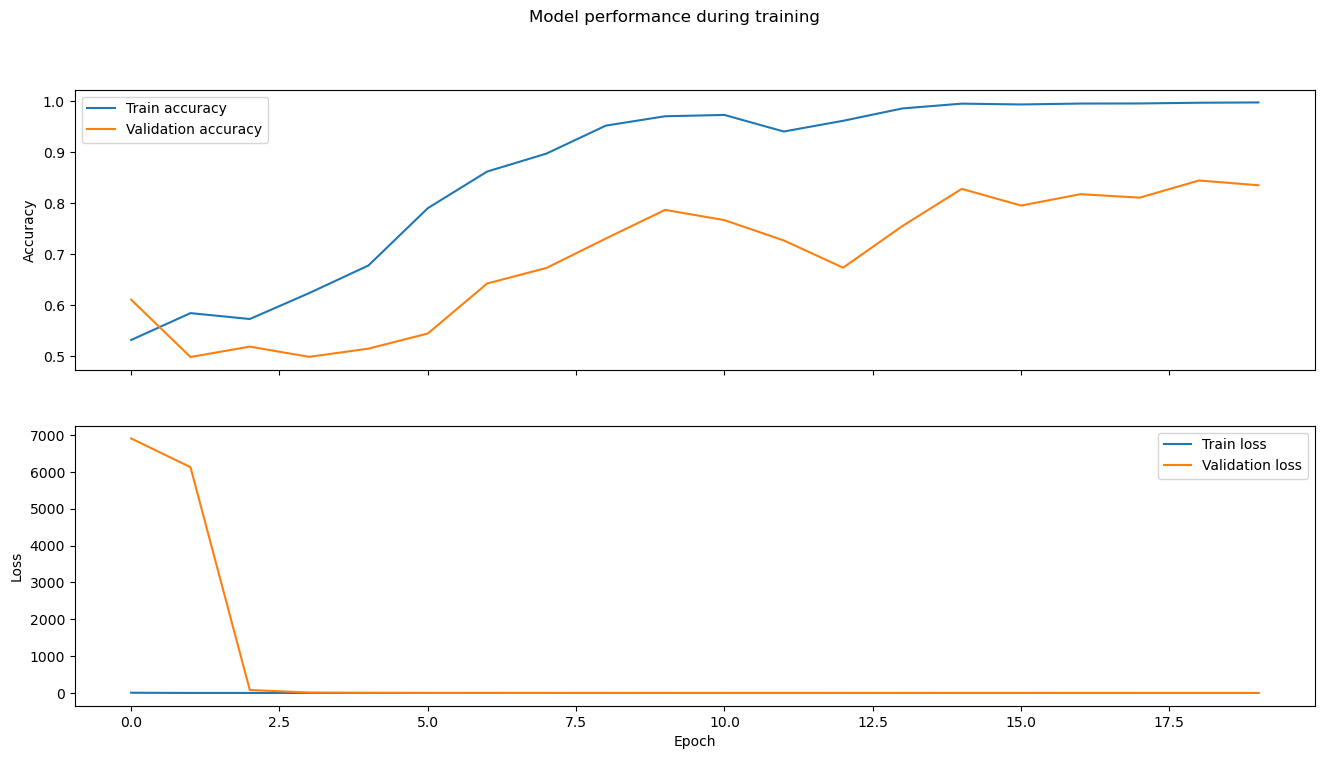

In [25]:
trainer_vgg16.plot_history()


## 3.3 Train ResNet50


In [29]:
# Define hyperparameters for model trainer
learning_rate = 0.001
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 256
epochs = 20


In [30]:
# Compile and train model
trainer_resnet50 = Trainer(resnet50, loss, optimizer, metrics)

# Compile model
trainer_resnet50.compile()

# Train model
trainer_resnet50.fit(train_set=train_set, val_set=val_set,
                     batch_size=batch_size, epochs=epochs)


Epoch 1/20
42/42 [==============================] - 213s 4s/step - loss: 0.6242 - accuracy: 0.6636 - val_loss: 1.3015 - val_accuracy: 0.4989
Epoch 2/20
42/42 [==============================] - 140s 3s/step - loss: 0.1969 - accuracy: 0.9268 - val_loss: 2.5870 - val_accuracy: 0.4989
Epoch 3/20
42/42 [==============================] - 138s 3s/step - loss: 0.0558 - accuracy: 0.9798 - val_loss: 4.2961 - val_accuracy: 0.4989
Epoch 4/20
42/42 [==============================] - 140s 3s/step - loss: 0.0299 - accuracy: 0.9903 - val_loss: 2.4286 - val_accuracy: 0.4989
Epoch 5/20
42/42 [==============================] - 143s 3s/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 1.5977 - val_accuracy: 0.5130
Epoch 6/20
42/42 [==============================] - 140s 3s/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 2.7655 - val_accuracy: 0.5212
Epoch 7/20
42/42 [==============================] - 145s 3s/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 4.3545 - val_accuracy: 0.5161
Epoch 8/20
42

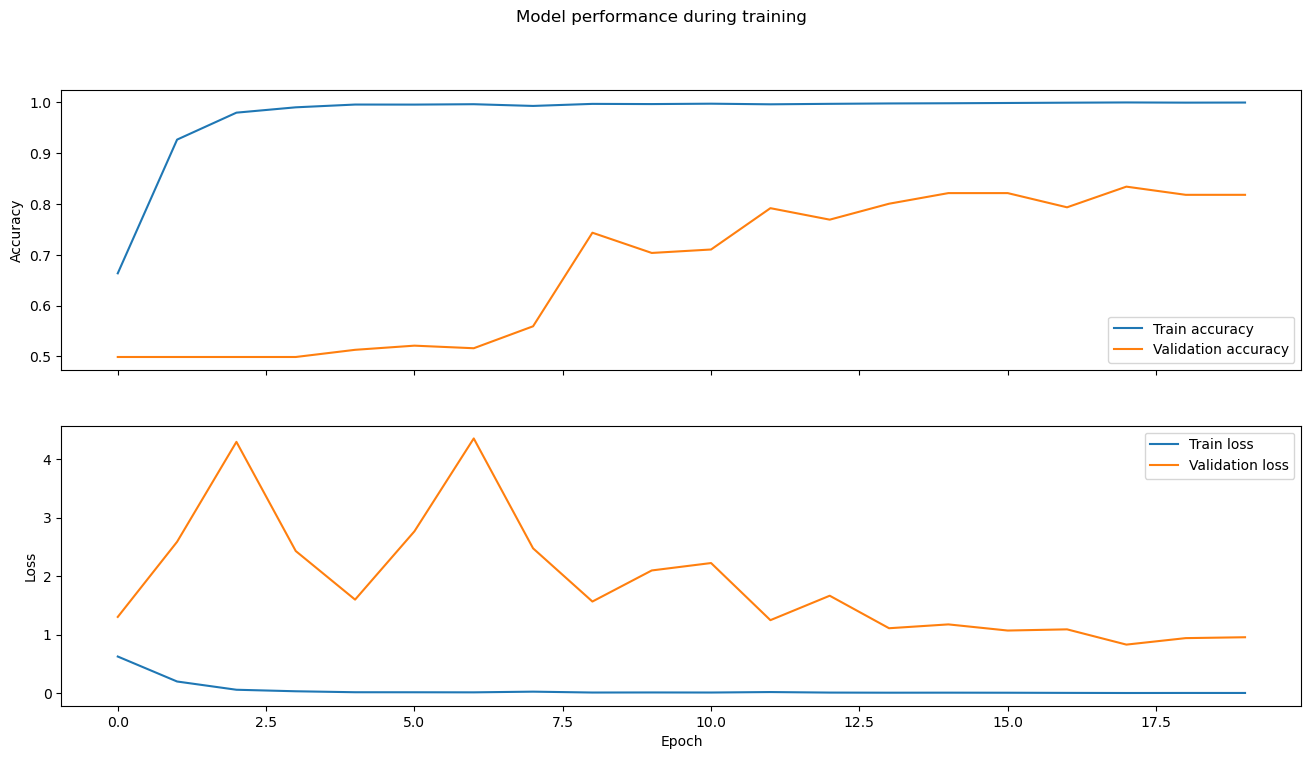

In [31]:
trainer_resnet50.plot_history()


## 3.4 Train DenseNet121


In [13]:
# Define hyperparameters for model trainer
learning_rate = 0.01
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 256
epochs = 20


In [14]:
# Compile and train model
trainer_densenet121 = Trainer(densenet121, loss, optimizer, metrics)

# Compile model
trainer_densenet121.compile()

# Train model
trainer_densenet121.fit(train_set=train_set, val_set=val_set,
                        batch_size=batch_size, epochs=epochs)


Epoch 1/20

42/42 [==============================] - 181s 3s/step - loss: 1.4876 - accuracy: 0.5770 - val_loss: 1076522909696.0000 - val_accuracy: 0.4989

Epoch 2/20

42/42 [==============================] - 137s 3s/step - loss: 0.8767 - accuracy: 0.6334 - val_loss: 14311893.0000 - val_accuracy: 0.4989

Epoch 3/20

42/42 [==============================] - 138s 3s/step - loss: 0.4367 - accuracy: 0.8056 - val_loss: 19826.1719 - val_accuracy: 0.4989

Epoch 4/20

42/42 [==============================] - 139s 3s/step - loss: 0.2815 - accuracy: 0.8853 - val_loss: 4819.8994 - val_accuracy: 0.5020

Epoch 5/20

42/42 [==============================] - 136s 3s/step - loss: 0.4951 - accuracy: 0.8499 - val_loss: 11.8556 - val_accuracy: 0.5633

Epoch 6/20

42/42 [==============================] - 137s 3s/step - loss: 0.1580 - accuracy: 0.9377 - val_loss: 1.4567 - val_accuracy: 0.6746

Epoch 7/20

42/42 [==============================] - 140s 3s/step - loss: 0.0857 - accuracy: 0.9686 - val_loss: 1.6

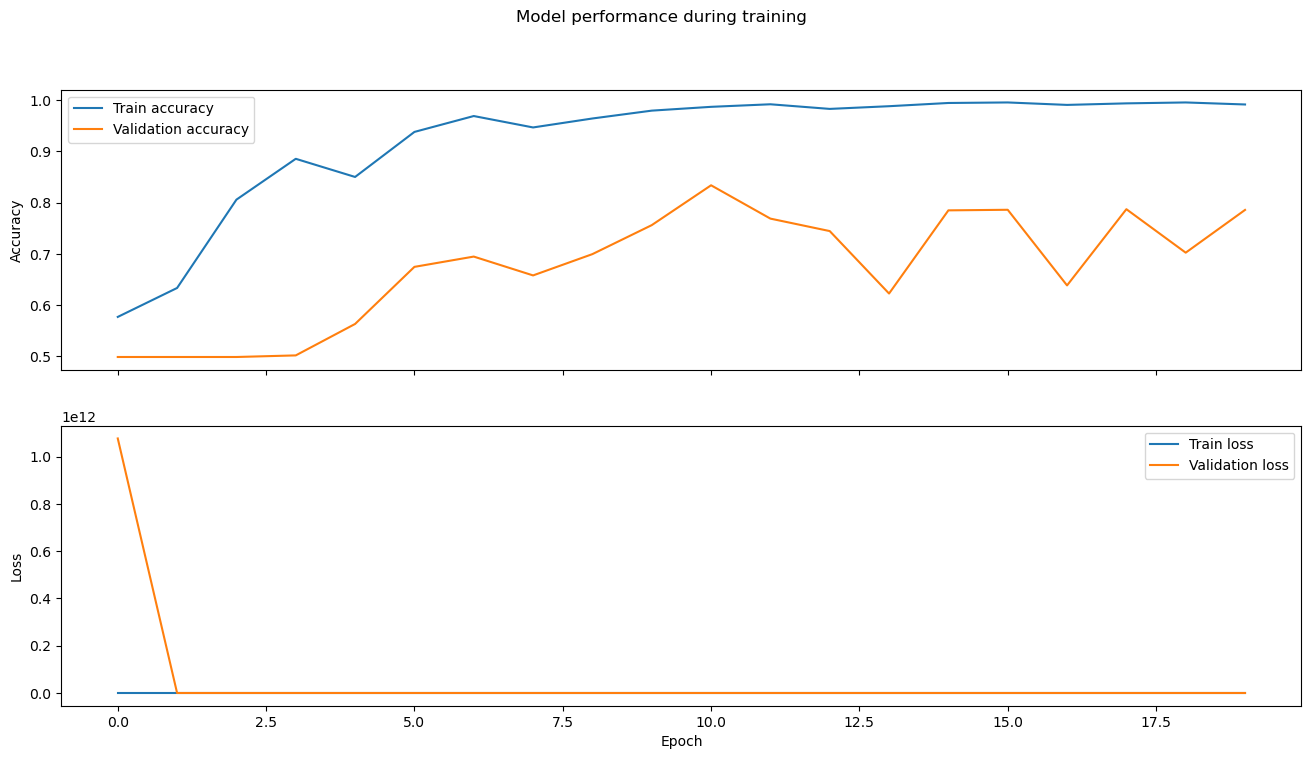

In [15]:
trainer_densenet121.plot_history()


# 4. Evaluate model


## 4.1 Define evaluator


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


class Evaluator:

    def __init__(self, model, test_set):
        self.model = model

        self.test_loss, self.test_acc = self.model.evaluate(
            test_set, verbose=1)

        y_pred = self.model.predict(test_set)
        y_true = test_set.classes
        y_pred = np.argmax(y_pred, axis=1)

        self.cm = confusion_matrix(y_true, y_pred)

        self.report = classification_report(y_true, y_pred)

    def evaluate(self):
        """
        Method to evaluate model and return loss and accuracy
        """
        return self.test_loss, self.test_acc

    def confusion_matrix(self):
        """
        Method to plot confusion matrix
        """
        sns.heatmap(self.cm, annot=True, fmt="d")
        plt.show()

    def classification_report(self):
        """
        Method to print classification report on test set
        """
        return self.report


## 4.2 Evaluate VGG16


In [27]:
evaluate_vgg16 = Evaluator(vgg16, test_set)


15/15 [==============================] - 55s 4s/step - loss: 1.4440 - accuracy: 0.8266

15/15 [==============================] - 33s 2s/step


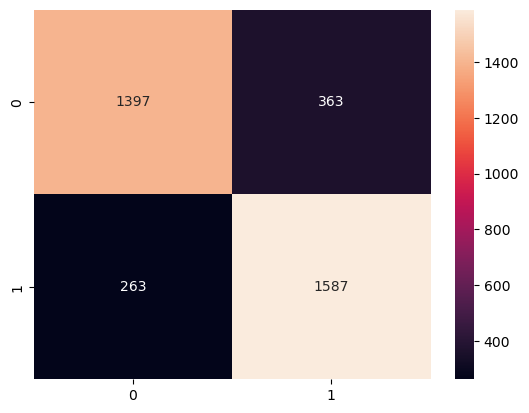

In [29]:
evaluate_vgg16.confusion_matrix()


In [30]:
print(evaluate_vgg16.classification_report())


              precision    recall  f1-score   support



           0       0.84      0.79      0.82      1760

           1       0.81      0.86      0.84      1850



    accuracy                           0.83      3610

   macro avg       0.83      0.83      0.83      3610

weighted avg       0.83      0.83      0.83      3610




## 4.3 Evaluate ResNet50


In [35]:
evaluate_resnet50 = Evaluator(resnet50, test_set)


15/15 [==============================] - 33s 2s/step


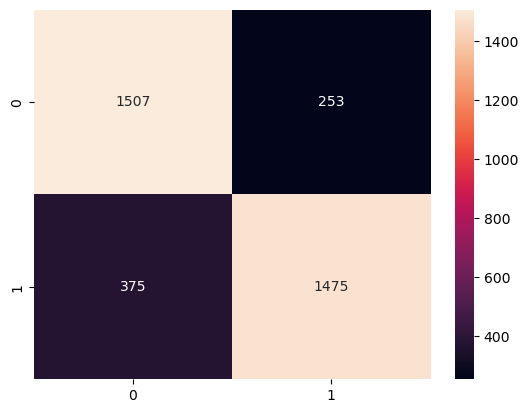

In [36]:
evaluate_resnet50.confusion_matrix()


In [37]:
print(evaluate_resnet50.classification_report())


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1760
           1       0.85      0.80      0.82      1850

    accuracy                           0.83      3610
   macro avg       0.83      0.83      0.83      3610
weighted avg       0.83      0.83      0.83      3610



## 4.4 Evaluate DenseNet121


In [18]:
evaluate_densenet121 = Evaluator(densenet121, test_set)


15/15 [==============================] - 61s 4s/step - loss: 0.7871 - accuracy: 0.8274

15/15 [==============================] - 34s 2s/step


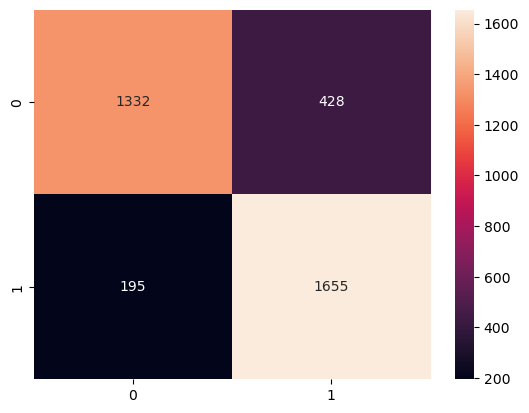

In [20]:
evaluate_densenet121.confusion_matrix()


In [21]:
print(evaluate_densenet121.classification_report())


              precision    recall  f1-score   support



           0       0.87      0.76      0.81      1760

           1       0.79      0.89      0.84      1850



    accuracy                           0.83      3610

   macro avg       0.83      0.83      0.83      3610

weighted avg       0.83      0.83      0.83      3610




# 5. Benchmark model


Benchmark ResNet50 model of Tensorflow and Tensorflow Lite format on test set


## 5.1 Server resources


In [24]:
import subprocess
from ast import literal_eval


def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())


print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# OS')
run('uname -a')

print('# GPU')
run('lspci | grep -i "VGA\|3D" | cut -d ":" -f 3 | cut -d "[" -f 1')


# CPU

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz

cpu MHz		: 2000.136

cpu cores	: 1

# RAM

MemTotal:       16390784 kB

# OS

Linux 18196358795f 5.15.120+ #1 SMP Wed Jul 26 10:54:59 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux

# GPU

Red Hat, Inc. Virtio SCSI

 NVIDIA Corporation GP100GL


## 5.2 Save model


In [39]:
# Save with Tensorflow format
tf_path = trainer_resnet50.save_model()

# Save with Tensorflow Lite format
tflite_path = trainer_resnet50.convert_to_tflite()


## 5.3 Reload and evaluate model


In [40]:
# Re-generate test set
batch_size = 1
target_size = (224, 224)
data_gen = DataGenerator(batch_size, target_size)
test_set = data_gen.generate_data('test', shuffle=False)


Found 3610 images belonging to 2 classes.
{'0': 0, '1': 1}


### Tensorflow


In [44]:
import time

loaded_model = tf.keras.models.load_model(tf_path)

# Evaluate the model on the test set and measure the time taken
start_time = time.monotonic()

test_loss, test_accuracy = loaded_model.evaluate(test_set, verbose=1)

end_time = time.monotonic()
total_time = end_time - start_time

print('Test accuracy:', test_accuracy)
print('Total time taken:', total_time, 'seconds')
print('FPS on test set:', test_set.n//total_time)


3610/3610 [==============================] - 61s 17ms/step - loss: 0.7726 - accuracy: 0.8260
Test accuracy: 0.8260387778282166
Total time taken: 83.39822418199947 seconds
FPS on test set: 43.0


### Tensorflow Lite


In [43]:
import numpy as np
import tensorflow as tf
import time


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# Evaluate the model on the test set
correct = 0
total = 0
total_time = 0
for i in range(test_set.n):
    # Get the next image and label from the test set
    image, label = test_set.next()

    # Preprocess the image
    image = image.astype('float32')

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run the inference and measure the time taken
    start_time = time.monotonic()
    interpreter.invoke()
    end_time = time.monotonic()
    inference_time = end_time - start_time

    total_time += inference_time

    # Get the output tensor
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted label
    predicted_label = np.argmax(predictions)

    # Update the counts
    correct += int(predicted_label == np.argmax(label))
    total += 1

accuracy = correct / total
print('Test accuracy:', accuracy)
print('Total time taken:', total_time, 'seconds')
print('FPS on test set:', test_set.n//total_time)


Test accuracy: 0.8260387811634349
Total time taken: 105.97767309208211 seconds
FPS on test set: 34.0
